In [1]:
!pip install numpy_indexed

In [2]:
!pip install imutils

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, transforms, datasets
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas
import ast
import os
from PIL import Image
import time
import copy
import numpy_indexed as npi
import imutils
import cv2
from google.colab.patches import cv2_imshow

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
if os.path.exists(os.path.expanduser('~/data')):
  !rm -rf {os.path.expanduser('~/data')}
!unzip '/content/drive/My Drive/APS360 Project/share/BerendImages/mayacaptures.zip' -d {os.path.expanduser('~/data')}

Streaming output truncated to the last 5000 lines.
  inflating: /root/data/6232/6232 303R_1.png  
  inflating: /root/data/6232/6232 304L_1.png  
  inflating: /root/data/6232/6232 304R_1.png  
  inflating: /root/data/6232/6232 305L_1.png  
  inflating: /root/data/6232/6232 305R_1.png  
  inflating: /root/data/6232/6232 306L_1.png  
  inflating: /root/data/6232/6232 306R_1.png  
  inflating: /root/data/6232/6232 307L_1.png  
  inflating: /root/data/6232/6232 307R_1.png  
  inflating: /root/data/6232/6232 308L_1.png  
  inflating: /root/data/6232/6232 308R_1.png  
  inflating: /root/data/6232/6232 309L_1.png  
  inflating: /root/data/6232/6232 309R_1.png  
  inflating: /root/data/6232/6232 310L_1.png  
  inflating: /root/data/6232/6232 310R_1.png  
  inflating: /root/data/6232/6232 311L_1.png  
  inflating: /root/data/6232/6232 311R_1.png  
  inflating: /root/data/6232/6232 312L_1.png  
  inflating: /root/data/6232/6232 312R_1.png  
  inflating: /root/data/6232/6232 313L_1.png  
  inflati

In [8]:
# load bad ones too
!unzip '/content/drive/My Drive/APS360 Project/heyed.zip' -d {os.path.expanduser('~/data')}

Archive:  /content/drive/My Drive/APS360 Project/heyed.zip
   creating: /root/data/heyed/
  inflating: /root/data/__MACOSX/._heyed  
  inflating: /root/data/heyed/348.png  
  inflating: /root/data/heyed/412.png  
  inflating: /root/data/heyed/374.png  
  inflating: /root/data/heyed/360.png  
  inflating: /root/data/heyed/406.png  
  inflating: /root/data/heyed/176.png  
  inflating: /root/data/heyed/88.png  
  inflating: /root/data/heyed/610.png  
  inflating: /root/data/heyed/604.png  
  inflating: /root/data/heyed/162.png  
  inflating: /root/data/heyed/189.png  
  inflating: /root/data/heyed/77.png  
  inflating: /root/data/heyed/63.png  
  inflating: /root/data/heyed/758.png  
  inflating: /root/data/heyed/764.png  
  inflating: /root/data/heyed/770.png  
  inflating: /root/data/heyed/228.png  
  inflating: /root/data/heyed/566.png  
  inflating: /root/data/heyed/200.png  
  inflating: /root/data/heyed/214.png  
  inflating: /root/data/heyed/572.png  
  inflating: /root/data/heyed/

In [9]:
!rm -rf {os.path.expanduser('~/data/__MACOSX')}

In [10]:
# Transform Settings - resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Resize((224,224)), 
                                     transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor()])

# define dataloader parameters
num_workers = 4
batch_size = 1

# get dataset
image_set = datasets.ImageFolder(os.path.expanduser('~/data'), transform=data_transform)

# put data inside loader
loader = torch.utils.data.DataLoader(image_set, batch_size=batch_size, 
                                        num_workers=num_workers, shuffle=False)

In [11]:
print(image_set.class_to_idx)
classes = os.listdir(os.path.expanduser('~/data'))
classes.sort()
classes = classes[:]
print(classes)
print(len(classes))
totalCount = 0
for c in classes:
  totalCount += len(os.listdir(os.path.join(os.path.expanduser('~/data'), c)))
print(totalCount)

{'11211': 0, '15571': 1, '22388': 2, '2456': 3, '3001': 4, '3003': 5, '3004': 6, '3007': 7, '3008': 8, '3009': 9, '30136': 10, '3039': 11, '3040': 12, '3044c': 13, '3062b': 14, '35464': 15, '3659': 16, '3660': 17, '3665': 18, '3941': 19, '4070': 20, '42023': 21, '4589b': 22, '4727': 23, '4733': 24, '50950': 25, '54200': 26, '6111': 27, '6232': 28, '6249': 29, '6541': 30, '85984': 31, '87081': 32, '87087': 33, '98100': 34, 'heyed': 35}
['11211', '15571', '22388', '2456', '3001', '3003', '3004', '3007', '3008', '3009', '30136', '3039', '3040', '3044c', '3062b', '35464', '3659', '3660', '3665', '3941', '4070', '42023', '4589b', '4727', '4733', '50950', '54200', '6111', '6232', '6249', '6541', '85984', '87081', '87087', '98100', 'heyed']
36
28742


In [ ]:
data_sheet = pandas.read_excel("/content/drive/My Drive/APS360 Project/share/Berend DAE Files/lego.xlsx")

In [ ]:
# Get parts list - use indices of each part as "label", for one-hot encoding
parts_list = []
with open('/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/BerendPartsList') as f:
  for line in f:
    word = line[:len(line) - 1] # get rid of '\n
    parts_list.append(int(word))

print(len(parts_list))

85


In [12]:
csv_path = '/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/Berend/CSV/labels.csv'
data_sheet_path = '/content/drive/My Drive/APS360 Project/share/Berend DAE Files/lego.xlsx'
image_path = '/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/Berend/Images'
bbox_label_root = '/content/drive/My Drive/APS360 Project/finalOutput'

In [13]:
class BerendDataset(Dataset):
  # For our dataset, let us accept a CSV file as input
  # + a list of parts, for a one-hot encoding.
  # We will also accept a root directory for images. 
  # We also accept transformations to the image
  def __init__(self, csv_path, data_sheet_path, class_dict, image_root, transforms, bbox_root):
    self.csv_path = csv_path
    self.parts_number_dict = {}
    self.class_dict = class_dict
    self.image_root = image_root
    data = pandas.read_csv(csv_path)
    lego_data_sheet = pandas.read_excel(data_sheet_path)

    for i in range(len(lego_data_sheet["Element Id"])):
      self.parts_number_dict[str(lego_data_sheet["Element Id"][i])] = str(lego_data_sheet["DesignId"][i])
    
    # Convert label col to list of ints of part numbers:
    for i in range(len(data["Labels"])):
      label = data["Labels"][i]
      list_row = ast.literal_eval(label)
      data["Labels"][i] = list(map(lambda x: self.class_dict[self.parts_number_dict[x]], list_row))

    # Do same for Color column:
    for i in range(len(data["Color"])):
      label = data["Color"][i]
      list_row = ast.literal_eval(label)
      data["Color"][i] = torch.LongTensor(list(map(int, list_row)))
    
    self.data = data
    self.transforms = transforms
    self.bbox_root = bbox_root
    self.bbox_tracked = {}
    self._BBOX_COL_NAMES = ["Labels", "x_min", "y_min", "x_max", "y_max"]

  def __getitem__(self, idx):
    target = {}
    labels = self.data["Labels"][idx]

    filename = self.data["Name"][idx]
    #print(filename)
    img_path = os.path.join(self.image_root, filename + '.jpg')
    bbox_path = os.path.join(self.bbox_root, filename + '.csv')
    img = Image.open(img_path).convert("RGB")
    if self.transforms is not None:
      img = self.transforms(img)

    target["labels"] = torch.LongTensor(labels)

    if filename in self.bbox_tracked:
      bboxes = self.bbox_tracked[filename]
    else:
      bbox_data = pandas.read_csv(os.path.join(self.bbox_root, filename + '.csv'),
                                  skiprows=2,
                                  header=None,
                                  names=self._BBOX_COL_NAMES)
      bbox_data_np = bbox_data.to_numpy(dtype=np.int_)
      bbox_labels = bbox_data_np[:, 0]
      bbox_targets = bbox_data_np[:, 1:]
      bboxes = torch.zeros([len(labels), 4], dtype=torch.long)
      for i in range(len(bbox_labels)):
        bboxes[i, :] = torch.LongTensor(bbox_targets[i])
      self.bbox_tracked[filename] = bboxes

    target["boxes"] = bboxes
    
    return img, target
  def __len__(self):
        return len(self.data)

In [14]:
data_transform = transforms.Compose([transforms.Resize((1200)), transforms.Grayscale(num_output_channels=3)])
dataset = BerendDataset(csv_path=csv_path, data_sheet_path=data_sheet_path, class_dict=image_set.class_to_idx, image_root=image_path, transforms=data_transform, bbox_root=bbox_label_root)

In [ ]:
my_data = dataset.data
my_data_labels = my_data["Labels"]
label_lengths = {}
for label in my_data_labels:
  length = len(label)
  if (length not in label_lengths):
    label_lengths[length] = 1
  else:
    label_lengths[length] += 1
print(label_lengths)

{1: 152, 2: 135, 3: 116, 4: 95, 5: 87, 6: 72, 7: 57, 8: 42, 9: 33, 10: 27}


In [ ]:
data_item = dataset[9]

/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/Berend/Images/B_9.jpg


{'labels': tensor([11, 27, 11, 31]), 'boxes': tensor([[1393, 1643, 2467, 2598],
        [2619, 1789, 2910, 2023],
        [2897, 2497, 3295, 2769],
        [1551,  209, 1797,  392]])}


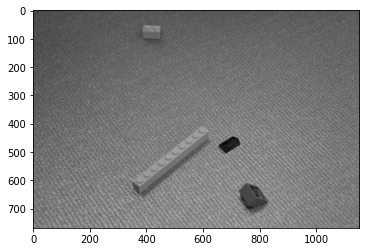

In [ ]:
image, target = data_item
print(target)
img = np.array(image)
plt.imshow(img)

In [15]:
class SlidingWindowDetector:
  def __init__(self, model):
    self.winW = 175
    self.winH = 175
    self.modelInputW = 224
    self.modelInputH = 224
    self.stepSize = 25
    self.scale = 1.25
    self.model = model

  def pyramid(self, image):
    minSize = (self.winW, self.winH)
    # yield the original image
    yield image
    # keep looping over the pyramid
    while True:
      # compute the new dimensions of the image and resize it
      w = int(image.shape[1] / self.scale)
      image = imutils.resize(image, width=w)
      # if the resized image does not meet the supplied minimum
      # size, then stop constructing the pyramid
      if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
        break
      # yield the next image in the pyramid
      yield image
  
  def sliding_window(self, image):
    windowSize = (self.winW, self.winH)
    # slide a window across the image
    for y in range(0, image.shape[0], self.stepSize):
      for x in range(0, image.shape[1], self.stepSize):
        # yield the current window
        yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

  def evaluate(self, image, plot=False):
    pieces = []
    # loop over the image pyramid
    iteration = 0
    clone = image.copy()
    for resized in self.pyramid(image):
      # loop over the sliding window for each layer of the pyramid
      for (x, y, window) in self.sliding_window(resized):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != self.winH or window.shape[1] != self.winW:
          continue
        window_resized = cv2.resize(window, (self.modelInputW, self.modelInputH))
        window_tensor = torch.FloatTensor(np.transpose(window_resized, [2, 1, 0])).unsqueeze(0)
        with torch.no_grad():
          out = alexnet.features(window_tensor.cuda())
          out = self.model(out)
          out = F.softmax(out)
          out.cpu()
          pred = out.max(dim=1, keepdim=True)
          piece = pred[1].item()
          if (pred[0] > 0.85 and piece not in pieces):
            pieces.append(pred[1].item())
            # print(pred)
            if (plot):
              cv2.rectangle(clone, (int(x*(self.scale**iteration)), int(y*(self.scale**iteration))), (int((x + self.winW)*(self.scale**iteration)), int((y + self.winH)*(self.scale**iteration))), (0, 255, 0), 2)
      iteration += 1
    if (plot):
      cv2_imshow(clone)
    return pieces


In [16]:
class TransferLearningNetDp5(nn.Module):
  def __init__(self, p=0.0):
    super(TransferLearningNetDp5, self).__init__()
    self.name = "tNetDp3"
    self.fc1 = nn.Linear(256*6*6, 3600)
    self.fc2 = nn.Linear(3600, 1200)
    self.fc3 = nn.Linear(1200, len(classes))
    # classes is 36 here
    self.dropout = nn.Dropout(p=p)
  
  def forward(self, x):
    x = x.view(-1, 256*6*6)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    x = self.dropout(x)
    return x

tNet = TransferLearningNetDp5()

In [17]:
tNet.load_state_dict(torch.load('/content/drive/My Drive/APS360 Project/Models/FeatureTransfer/model_tNetDp3_bs400_lr0.0015_epoch92'))
tNet = tNet.eval()

In [18]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)
alexnet.features.cuda()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

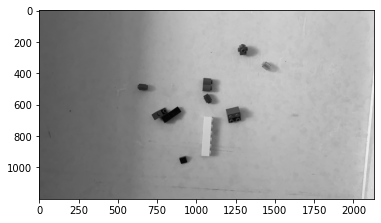

In [30]:
image = Image.open("/content/116346729_1491382804402775_7503898132831356357_n.jpg")
image = transforms.Resize((1200))(image)
image = transforms.Grayscale(num_output_channels=3)(image)
image_np = np.array(image)
plt.imshow(image)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


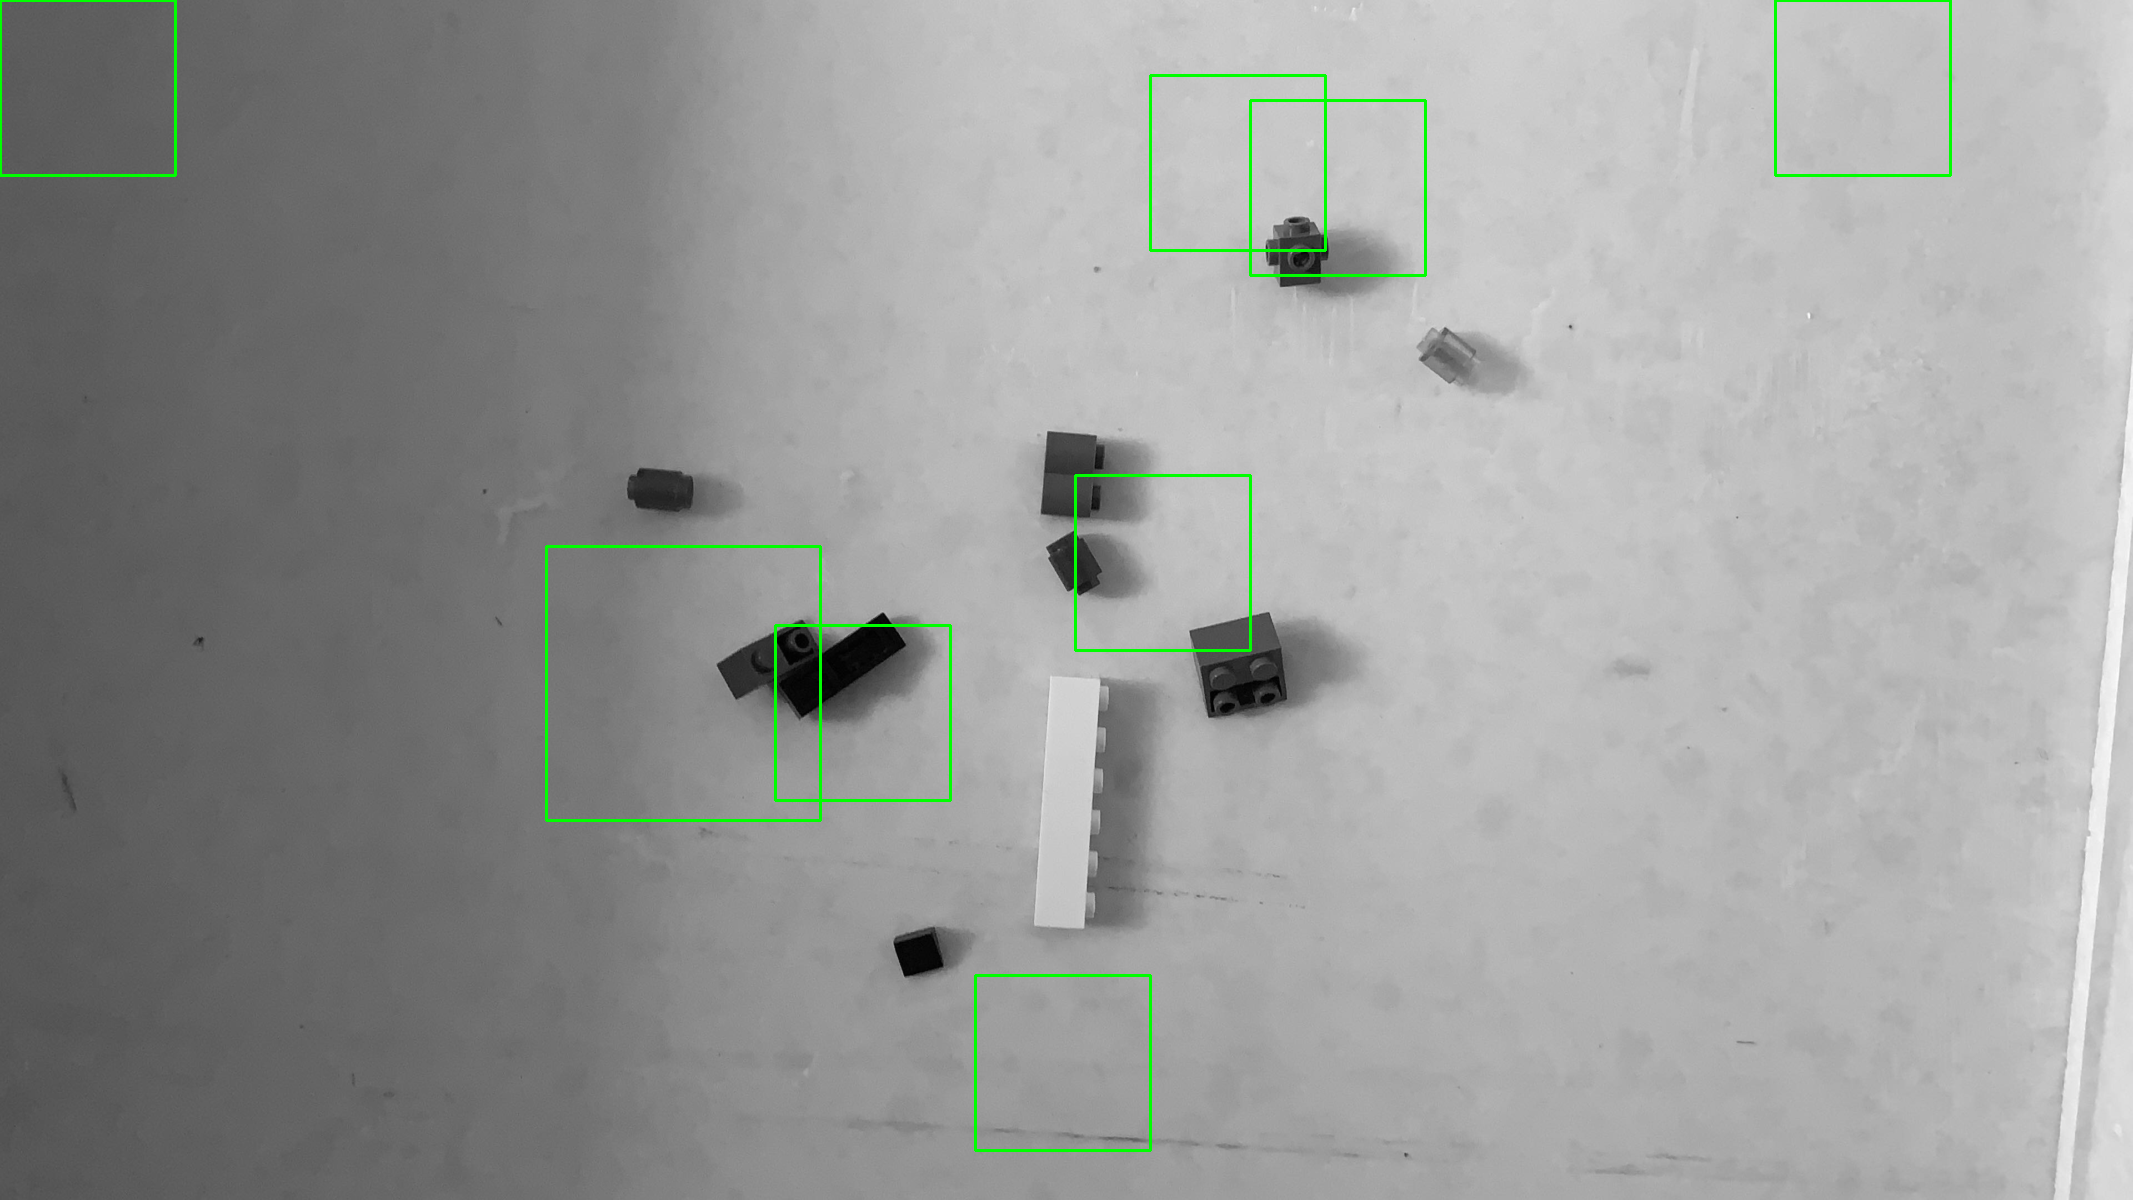

[23, 27, 7, 29, 4, 3, 35, 24]


In [31]:
tNet.cuda()
detector = SlidingWindowDetector(tNet)
labels = detector.evaluate(image_np, plot=True)
print(labels)

In [ ]:
correct = 0
total_predictions = 0
total_labels = 0
count = 0
for image, target in dataset:
  image_np = np.array(image)
  labels = detector.evaluate(image_np)
  labels_np = np.array(labels)
  targets_np = (target["labels"]).numpy()

  correct += min(npi.in_(labels_np, targets_np).sum(), npi.in_(targets_np, labels_np).sum())
  total_predictions += len(labels_np)
  total_labels += len(targets_np)

  if (count%20 == 0):
    print("Correct: {}, Total Predictions: {}, Total Labels: {}".format(correct, total_predictions, total_labels))
  count += 1

print("Correct: {}, Total Predictions: {}, Total Labels: {}".format(correct, total_predictions, total_labels))
if (total_predictions == 0):
    precision = 0
else:
    precision = correct/total_predictions

if (total_labels == 0):
    recall = 0
else:
    recall = correct/total_labels

print("Precision: {:.4f} Recall: {:.4f}".format(precision, recall))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Correct: 0, Total Predictions: 2, Total Labels: 1
Correct: 10, Total Predictions: 81, Total Labels: 84
Correct: 15, Total Predictions: 158, Total Labels: 191
Correct: 23, Total Predictions: 239, Total Labels: 261
Correct: 29, Total Predictions: 298, Total Labels: 321
Correct: 32, Total Predictions: 367, Total Labels: 358
Correct: 35, Total Predictions: 451, Total Labels: 474
Correct: 36, Total Predictions: 521, Total Labels: 536
Correct: 51, Total Predictions: 646, Total Labels: 639
Correct: 59, Total Predictions: 745, Total Labels: 716
Correct: 60, Total Predictions: 838, Total Labels: 771
Correct: 69, Total Predictions: 946, Total Labels: 840
Correct: 82, Total Predictions: 1064, Total Labels: 917
Correct: 90, Total Predictions: 1157, Total Labels: 999
Correct: 90, Total Predictions: 1254, Total Labels: 1086
Correct: 92, Total Predictions: 1347, Total Labels: 1223
Correct: 106, Total Predictions: 1464, Total Labels: 1266
Correct: 126, Total Predictions: 1581, Total Labels: 1389
Corre

KeyError: ignored

In [ ]:
print("Correct: {}, Total Predictions: {}, Total Labels: {}".format(correct, total_predictions, total_labels))
if (total_predictions == 0):
    precision = 0
else:
    precision = correct/total_predictions

if (total_labels == 0):
    recall = 0
else:
    recall = correct/total_labels

print("Precision: {:.4f}% Recall: {:.4f}%".format(precision*100, recall*100))

Correct: 253, Total Predictions: 4039, Total Labels: 3319
Precision: 6.2639% Recall: 7.6228%
